In [0]:
import os
import matplotlib.pyplot as plt
import random
import shutil
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from google.colab import files
from numpy import loadtxt

from PIL import Image
import cv2 as cv
import pandas as pd
import numpy as np
import scipy.io
from tqdm import tqdm
from scipy.io import loadmat
from pathlib import Path
import torchvision.models as models

import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from keras.utils import np_utils

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, AvgPool2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.applications.resnet50 import ResNet50 
from keras.applications.vgg16 import vgg16
from keras.models import load_model
from tensorflow.keras.utils import plot_model
#!pip install pyyaml h5py

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **Processing the images**

In [0]:
data_dir = '/content/drive/My Drive/datasets/Datasets/'

images = []
car_types = []
for car_type in ["car","truck"]:
    car_dir = data_dir + car_type
    car_files = [car_dir + '/' + filename for filename in os.listdir(car_dir)]
    #print(car_files)
    for filename in car_files:
        if filename.endswith('jpg'):
            try:
                images.append(cv.resize(cv.imread(filename), (224,224), interpolation=cv.INTER_CUBIC))
                car_types.append(car_type)
            except Exception as e:
                print(str(e))
            
            
images = np.array(images)
car_types = np.array(car_types)

le = LabelEncoder()
car_types_encoded = le.fit_transform(car_types)
car_types_encoded = car_types_encoded.reshape((images.shape[0],1))
car_types_encoded_onehot = np_utils.to_categorical(car_types_encoded)

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



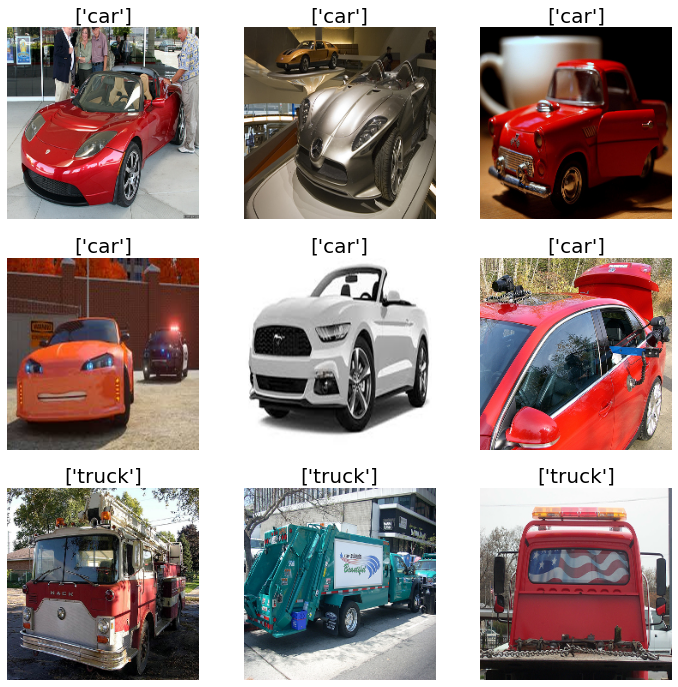

In [0]:
_, ax = plt.subplots(3,3, figsize=(12,12))
for i in range(3):
    for j in range(3):
      ax[i,j].imshow(cv.cvtColor(images[(i*300)+j], cv.COLOR_BGR2RGB))
      ax[i,j].axis('off')
      ax[i,j].set_title(le.inverse_transform(car_types_encoded[(i*300)+j]), size = 20)

In [0]:
images, car_types, car_types_encoded = shuffle(images, car_types, car_types_encoded)
car_types_encoded.resize((images.shape[0],1))
print(car_types_encoded.shape)

(788, 1)


In [0]:
model = Sequential()

model.add(Conv2D(32, (3, 3),input_shape=(224, 224, 3),strides = (1,1),  padding = 'same',kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(AvgPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu', kernel_initializer='normal'))
model.add(Dense(units=2, activation='sigmoid', kernel_initializer='normal'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
average_pooling2d_1 (Average (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)       

In [0]:
car_types_encoded = car_types_encoded.reshape((images.shape[0],1))
car_types_2class = np.zeros((images.shape[0],2))
for i in range(images.shape[0]):
    if car_types_encoded[i][0] == 0:
        car_types_2class[i][0] = 1
    else:
        car_types_2class[i][1] = 1

x_train, x_val, y_train, y_val = train_test_split(images, car_types_2class, test_size=0.2, random_state=0)
x_train = x_train / 255
x_val = x_val / 255

# set train Generator
datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
datagen.fit(x_train)


In [0]:
epochs = 30
batch_size = 4

fitted_model = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch = x_train.shape[0],
                    epochs=epochs,
                    validation_data = (x_val, y_val)
                    )

Epoch 1/30
630/630 [==============================] - 39s 61ms/step - loss: 0.6867 - accuracy: 0.5527 - val_loss: 0.6791 - val_accuracy: 0.5601
Epoch 2/30
630/630 [==============================] - 31s 49ms/step - loss: 0.6746 - accuracy: 0.5661 - val_loss: 0.6763 - val_accuracy: 0.5886
Epoch 3/30
630/630 [==============================] - 31s 49ms/step - loss: 0.6526 - accuracy: 0.6154 - val_loss: 0.6373 - val_accuracy: 0.5633
Epoch 4/30
630/630 [==============================] - 31s 49ms/step - loss: 0.6429 - accuracy: 0.6200 - val_loss: 0.6297 - val_accuracy: 0.5918
Epoch 5/30
630/630 [==============================] - 31s 49ms/step - loss: 0.6302 - accuracy: 0.6359 - val_loss: 0.6315 - val_accuracy: 0.5918
Epoch 6/30
630/630 [==============================] - 30s 48ms/step - loss: 0.6265 - accuracy: 0.6268 - val_loss: 0.6422 - val_accuracy: 0.6203
Epoch 7/30
630/630 [==============================] - 30s 47ms/step - loss: 0.6264 - accuracy: 0.6395 - val_loss: 0.6087 - val_accuracy:

In [0]:
model_name = 'firstSequential.pt'
path = '/content/drive/My Drive/datasets/firstSequential'
torch.save(model,path)

#the_model = Sequential()
#the_model.load_state_dict(torch.load(PATH))

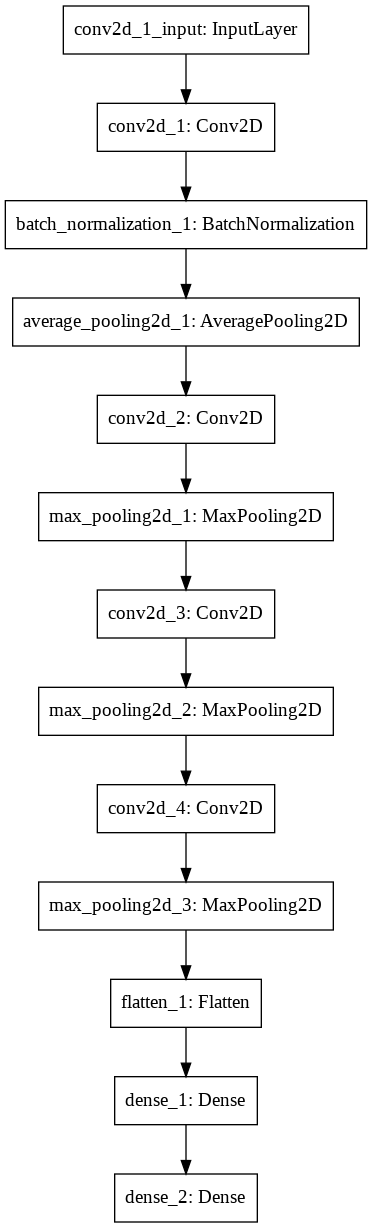

In [0]:
plot_model(model, to_file='model.png')

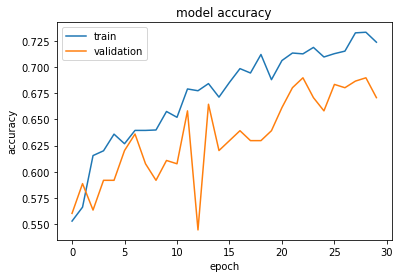

<Figure size 432x288 with 0 Axes>

In [0]:
#plotting model accuracy

plt.plot(fitted_model.history['accuracy'])
plt.plot(fitted_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()
plt.savefig("modelgraph.jpg")
files.download("modelgraph.jpg")

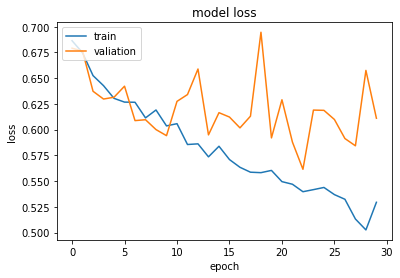

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure()
plt.gcf().clear()
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valiation'], loc='upper left')

plt.show()
plt.savefig("model_loss.jpg")
files.download("model_loss.jpg")

In [0]:


scores = model.evaluate(x_train,y_train,verbose=0)
print("Accuracy on train set", (scores[1]*100))
scores = model.evaluate(x_val,y_val, verbose=0)
print("Accuracy on validation set",(scores[1]*100))




Accuracy on train set 77.85714268684387
Accuracy on validation set 67.08860993385315


In [0]:
#LeNet

img_size = 224

le_Model = Sequential([  
   Conv2D(filters=6, kernel_size=(5,5), activation='relu', input_shape=(img_size,img_size,3)),
   AvgPool2D(pool_size=(2,2), strides=(2,2)),

   Conv2D(filters=16, kernel_size=(5,5), activation='relu'),
   AvgPool2D(pool_size=(2,2), strides=(2,2)),
   Dropout(rate = 0.25),

   Flatten(),
   Dropout(rate = 0.25),

   Dense(units = 128, activation='relu',kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4)),
   Dropout(rate = 0.25),

   Dense(units = 84, activation='relu', kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4)),

   Dense(units = 2, activation = 'softmax')
])

le_Model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
le_Model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 220, 220, 6)       456       
_________________________________________________________________
average_pooling2d_3 (Average (None, 110, 110, 6)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 106, 106, 16)      2416      
_________________________________________________________________
average_pooling2d_4 (Average (None, 53, 53, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 53, 53, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 44944)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 44944)            

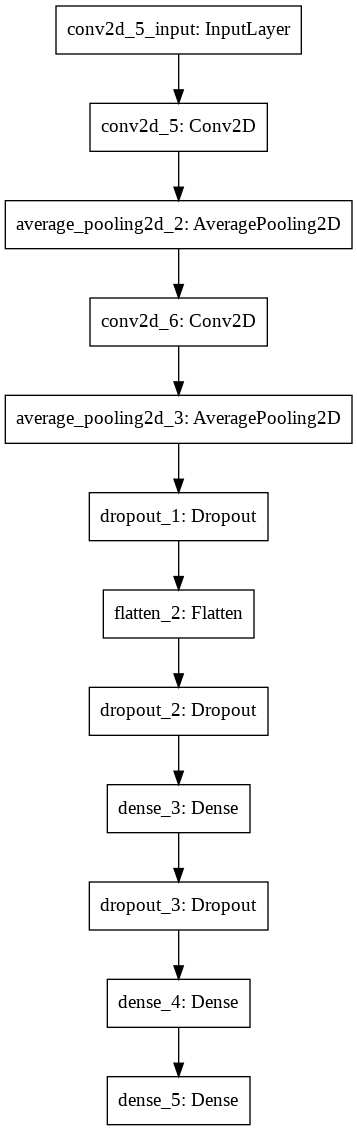

In [0]:
plot_model(le_Model, to_file='Lemodel.png')

In [0]:
epochs = 30
batch_size = 4

fitted_model3 = le_Model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch = x_train.shape[0],
                    epochs=epochs,
                    validation_data = (x_val, y_val),
                    )

Epoch 1/30
630/630 [==============================] - 36s 57ms/step - loss: 0.8284 - accuracy: 0.4948 - val_loss: 0.7628 - val_accuracy: 0.5000
Epoch 2/30
630/630 [==============================] - 36s 57ms/step - loss: 0.7288 - accuracy: 0.4881 - val_loss: 0.7142 - val_accuracy: 0.5316
Epoch 3/30
630/630 [==============================] - 36s 57ms/step - loss: 0.7210 - accuracy: 0.5024 - val_loss: 0.7161 - val_accuracy: 0.5127
Epoch 4/30
630/630 [==============================] - 36s 57ms/step - loss: 0.7077 - accuracy: 0.4745 - val_loss: 0.7032 - val_accuracy: 0.5000
Epoch 5/30
630/630 [==============================] - 36s 56ms/step - loss: 0.7024 - accuracy: 0.4900 - val_loss: 0.7012 - val_accuracy: 0.5000
Epoch 6/30
630/630 [==============================] - 35s 56ms/step - loss: 0.7010 - accuracy: 0.4889 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 7/30
630/630 [==============================] - 35s 56ms/step - loss: 0.7005 - accuracy: 0.4944 - val_loss: 0.7001 - val_accuracy:

In [0]:
model_name = 'LeNet.pt'
path = '/content/drive/My Drive/datasets/LeNet'
torch.save(le_Model,path)

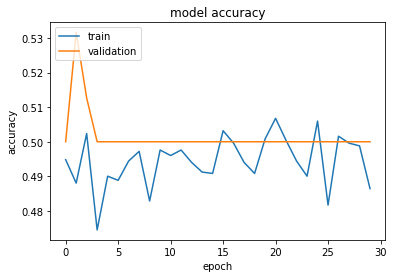

<Figure size 432x288 with 0 Axes>

In [0]:
#model accuracy for leNet
plt.plot(fitted_model3.history['accuracy'])
plt.plot(fitted_model3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()
plt.savefig("LeNetacc.png")
files.download("LeNetacc.png")

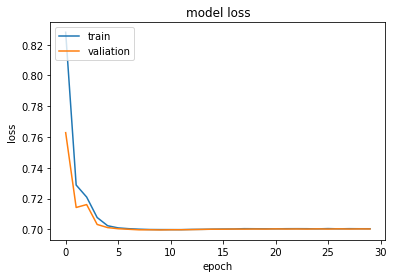

<Figure size 432x288 with 0 Axes>

In [0]:
#model loss for leNet
plt.figure()
plt.gcf().clear()
plt.plot(fitted_model3.history['loss'])
plt.plot(fitted_model3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valiation'], loc='upper left')

plt.show()
plt.savefig("lenet_loss.jpg")
files.download("lenet_loss.jpg")

In [0]:

scores = le_Model.evaluate(x_train,y_train,verbose=0)
print("Accuracy on train set", (scores[1]*100))
scores = le_Model.evaluate(x_val,y_val, verbose=0)
print("Accuracy on validation set",(scores[1]*100))



Accuracy on train set 50.31746029853821
Accuracy on validation set 50.0


In [0]:
#fine tuning resnet 50 pretrained with imagenet weights, imagenet weights are available online
def build_ResNet50(input_tensor_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape= input_tensor_shape)  #usingimagenet weights
    
    x_model = base_model.output
    
    x_model = AvgPool2D(name='globalaveragepooling2d')(x_model)
    
    x_model = Dense(1024, activation='relu',name='Dense1')(x_model)
    x_model = Dropout(0.5, name='dropout_1')(x_model)
    x_model = Flatten()(x_model)
    x_model = Dense(512, activation='relu',name='Dense2')(x_model)
    x_model = Dropout(0.5, name='dropout_2')(x_model)
    
    predictions = Dense(2, activation='sigmoid',name='output_layer')(x_model)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model



input_tensor_shape = (224,224,3)

model2 = build_ResNet50(input_tensor_shape)

model2.summary()
model2.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
epoch = 10
batch_size = 4
#checkpointer = ModelCheckpoint('imagenet', verbose=1, monitor='val_acc',save_best_only=True, save_weights_only=True)
fitted_model2 = model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch = x_train.shape[0],
                    epochs=epoch,
                    validation_data = (x_val, y_val),
                    )

Epoch 1/10
630/630 [==============================] - 87s 138ms/step - loss: 0.6835 - accuracy: 0.6812 - val_loss: 0.7834 - val_accuracy: 0.6297
Epoch 2/10
630/630 [==============================] - 77s 122ms/step - loss: 0.4141 - accuracy: 0.8175 - val_loss: 0.3984 - val_accuracy: 0.8386
Epoch 3/10
630/630 [==============================] - 77s 122ms/step - loss: 0.3072 - accuracy: 0.8716 - val_loss: 0.3598 - val_accuracy: 0.8608
Epoch 4/10
630/630 [==============================] - 77s 122ms/step - loss: 0.2340 - accuracy: 0.9053 - val_loss: 0.3509 - val_accuracy: 0.8861
Epoch 5/10
630/630 [==============================] - 78s 124ms/step - loss: 0.1700 - accuracy: 0.9347 - val_loss: 0.2372 - val_accuracy: 0.9146
Epoch 6/10
630/630 [==============================] - 77s 123ms/step - loss: 0.1311 - accuracy: 0.9473 - val_loss: 0.4967 - val_accuracy: 0.8956
Epoch 7/10
630/630 [==============================] - 76s 121ms/step - loss: 0.1192 - accuracy: 0.9524 - val_loss: 0.4080 - val_ac

In [0]:
model_name = 'Rnet50.pt'
path = '/content/drive/My Drive/datasets/Rnet50'
torch.save(model2,path)

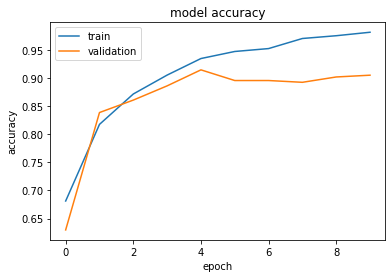

<Figure size 432x288 with 0 Axes>

In [0]:
#visualising model accuracy for ResNet50

plt.plot(fitted_model2.history['accuracy'])
plt.plot(fitted_model2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()
plt.savefig('resnetacc.jpg')
files.download("resnetacc.jpg")

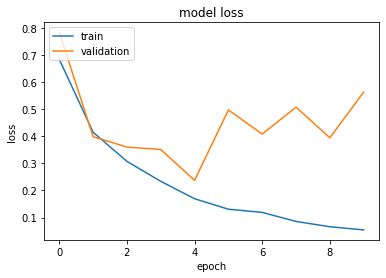

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure()
plt.gcf().clear() #clearing terminal
plt.plot(fitted_model2.history['loss'])
plt.plot(fitted_model2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()
plt.savefig('resnetaccloss.jpg')
files.download("resnetaccloss.jpg")

In [0]:


scores = model2.evaluate(x_train,y_train,verbose=0)
print("Accuracy on train set", (scores[1]*100))
scores = model2.evaluate(x_val,y_val, verbose=0)
print("Accuracy on validation set",(scores[1]*100))



Accuracy on train set 100.0
Accuracy on validation set 90.5063271522522


# **VGG16**

In [0]:
def build_VGG16(input_tensor_shape):
    base_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_tensor_shape)  #usingimagenet weights
    
    x_model = base_model.output
    x_model = Dense(512, activation='relu',name='Dense1')(x_model)
    x_model = Dropout(0.5, name='dropout_2')(x_model)
    x_model = Flatten()(x_model)
    
    predictions = Dense(2, activation='sigmoid',name='output_layer')(x_model)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model



input_tensor_shape = (224,224,3)

model4 = build_VGG16(input_tensor_shape)

model4.summary()
model4.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
epoch = 10
batch_size = 4

fitted_model4 = model4.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch = x_train.shape[0],
                    epochs=epoch,
                    validation_data = (x_val, y_val),
                    )


Epoch 1/10
630/630 [==============================] - 48s 76ms/step - loss: 0.5617 - accuracy: 0.6992 - val_loss: 0.4412 - val_accuracy: 0.7690
Epoch 2/10
630/630 [==============================] - 41s 64ms/step - loss: 0.3629 - accuracy: 0.8386 - val_loss: 0.2454 - val_accuracy: 0.8829
Epoch 3/10
630/630 [==============================] - 40s 64ms/step - loss: 0.2643 - accuracy: 0.8861 - val_loss: 0.1941 - val_accuracy: 0.9367
Epoch 4/10
630/630 [==============================] - 40s 64ms/step - loss: 0.2091 - accuracy: 0.9099 - val_loss: 0.2036 - val_accuracy: 0.9082
Epoch 5/10
630/630 [==============================] - 40s 64ms/step - loss: 0.1362 - accuracy: 0.9442 - val_loss: 0.2082 - val_accuracy: 0.9304
Epoch 6/10
630/630 [==============================] - 40s 64ms/step - loss: 0.1174 - accuracy: 0.9574 - val_loss: 0.2025 - val_accuracy: 0.9209
Epoch 7/10
630/630 [==============================] - 40s 64ms/step - loss: 0.0646 - accuracy: 0.9777 - val_loss: 0.2814 - val_accuracy:

In [0]:
model_name = 'vgg16.pt'
path = '/content/drive/My Drive/datasets/vgg16'
torch.save(model4,path)

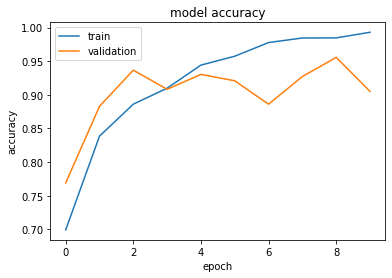

<Figure size 432x288 with 0 Axes>

In [0]:
#visualising model accuracy for vgg16

plt.plot(fitted_model4.history['accuracy'])
plt.plot(fitted_model4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()
plt.savefig('vggacc.jpg')
files.download("vggacc.jpg")

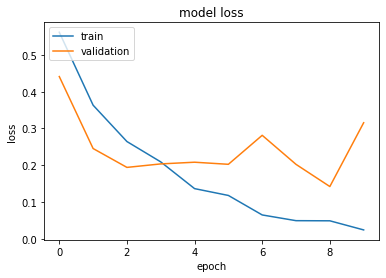

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure()
plt.gcf().clear() #clearing terminal
plt.plot(fitted_model4.history['loss'])
plt.plot(fitted_model4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()
plt.savefig('vggaccloss.jpg')
files.download("vggaccloss.jpg")

In [0]:
scores = model4.evaluate(x_train,y_train,verbose=0)
print("Accuracy on train set", (scores[1]*100))
scores = model4.evaluate(x_val,y_val, verbose=0)
print("Accuracy on validation set",(scores[1]*100))

Accuracy on train set 99.92063641548157
Accuracy on validation set 90.5063271522522
